<a href="https://colab.research.google.com/github/SLVmain/PyTorch_start/blob/les_06/HW_06_text_new_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 06 Text classification using CNN

Самостоятельно обучить классификатор текстов на примере 20newsgroups

На примере 20 newsgroups попробовать разные параметры для сверток для классификации текстов

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [2]:
feats = newsgroups_test.target_names
feats

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
len(feats)

20

In [4]:
df_train = pd.DataFrame(newsgroups_train.data,  columns=['text'])
df_train['target'] = pd.Series(data=newsgroups_train.target, index=df_train.index)

In [5]:
df_test = pd.DataFrame(newsgroups_test.data,  columns=['text'])
df_test['target'] = pd.Series(data=newsgroups_test.target, index=df_test.index)

In [6]:
df_train.head()

,text,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [7]:
df_test.head()

,text,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


In [8]:
print(df_train.shape)
print(df_test.shape)

(11314, 2)
(7532, 2)


In [9]:
max_words = 2000
max_len = 40
num_classes = len(feats)

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

### Предобработка

In [ ]:
pip install stop_words

In [ ]:
pip install nltk

In [12]:
from string import punctuation
from stop_words import get_stop_words
#from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
sw = set(get_stop_words("en"))
exclude = set(punctuation)
#morpher = MorphAnalyzer() для русского языка только
lemmatizer = WordNetLemmatizer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt =  re.sub('[^A-Za-z0-9]+', ' ', txt)
    txt = re.sub("not\s*", "not", txt)
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw]
    
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [14]:
df_train.head()

,text,target
0,lerxstwamumdedu wheres thing subject car nntpp...,7
1,guykuocarsonuwashingtonedu guy kuo subject si ...,4
2,twillisececnpurdueedu thomas e willis subject ...,4
3,jgreenamber joe green subject re weitek p9000 ...,1
4,jcmheadcfaharvardedu jonathan mcdowell subject...,14


In [15]:
from collections import Counter

In [16]:
text_corpus_train =  df_train['text'].values
text_corpus_test = df_test['text'].values

counts = Counter()
for sequence in text_corpus_train:
    counts.update(sequence.split())

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2: #10
        del counts[word]
print("num_words after:",len(counts.keys()))
    
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

num_words before: 134887
num_words after: 60386


In [17]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [18]:
from functools import lru_cache

class TwitterDataset(torch.utils.data.Dataset):
    
    def __init__(self, txts, labels, w2index, used_length):
        self._txts = txts
        self._labels = labels
        self._length = used_length
        self._w2index = w2index
        
    def __len__(self):
        return len(self._txts)
    
    @lru_cache(50000)
    def encode_sentence(self, txt):
        encoded = np.zeros(self._length, dtype=int)
        enc1 = np.array([self._w2index.get(word, self._w2index["UNK"]) for word in txt.split()])
        length = min(self._length, len(enc1))
        encoded[:length] = enc1[:length]
        return encoded, length
    
    def __getitem__(self, index):
        encoded, length = self.encode_sentence(self._txts[index])
        return torch.from_numpy(encoded.astype(np.int32)), float(self._labels[index]), length

In [19]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return nn.softmax(self.forward(x))

In [20]:
y_train = df_train['target'].values
y_test = df_test['target'].values

train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, 15)
valid_dataset = TwitterDataset(text_corpus_test, y_test, vocab2index, 15)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [ ]:
for i, data in enumerate(train_loader):
  print (data)
  break

In [21]:
from tqdm import tqdm_notebook

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [32]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valid_loader:
            images, labels, _ = data
            labels = labels.long()
            images = images.to(device)
            labels = labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [35]:
model = Net(vocab_size=len(vocab2index))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 50


print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

best_accuracy = 0
loss_history = []

model.train()
for epoch in tqdm_notebook(range(epochs)):  
    model.train()
    for i, (inputs, labels, _) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y, _ in valid_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = criterion(output, y.long())  #.float().view(-1, 1))
        loss_accumed += loss
    #print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
        
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy)) 

    
    loss = loss.float().item()
    print("Step {}: loss={}".format(epoch+1, loss))
    loss_history.append(loss)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy

print('Training is finished!')

Net(
  (embedding): Embedding(60388, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 7781524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 9 %
Step 1: loss=2.9205853939056396
For epoch 2 the test accuracy over the whole test set is 15 %
Step 2: loss=2.8663487434387207
For epoch 3 the test accuracy over the whole test set is 20 %
Step 3: loss=2.807030200958252
For epoch 4 the test accuracy over the whole test set is 24 %
Step 4: loss=2.7402048110961914
For epoch 5 the test accuracy over the whole test set is 26 %
Step 5: loss=2.6781790256500244
For epoch 6 the test accuracy over the whole test set is 28 %
Step 6: loss=2.610685348510742
For epoch 7 the test accuracy over the whole test set is 30 %
Step 7: loss=2.546854019165039
For epoch 8 the test accuracy over the whole test set is 31 %
Step 8: loss=2.495439052581787
For epoch 9 the test accuracy over the whole test set is 33 %
Step 9: loss=2.444441318511963
For epoch 10 the test accuracy over the whole test set is 34 %
Step 10: loss=2.3984222412109375
For epoch 11 the test accuracy over the whole test set is 36 %
S

Populating the interactive namespace from numpy and matplotlib


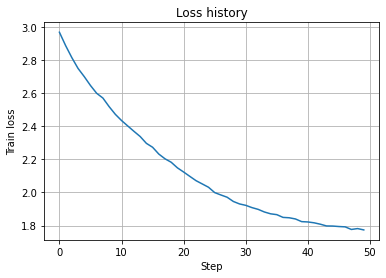

In [72]:
import matplotlib.pyplot as plt
%pylab inline
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [36]:
# меняем kernel size
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=5)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return nn.softmax(self.forward(x))

model = Net(vocab_size=len(vocab2index))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 50


print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

best_accuracy = 0
loss_history = []

model.train()
for epoch in tqdm_notebook(range(epochs)):  
    model.train()
    for i, (inputs, labels, _) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y, _ in valid_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = criterion(output, y.long())  #.float().view(-1, 1))
        loss_accumed += loss
    #print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
        
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy)) 

    
    loss = loss.float().item()
    print("Step {}: loss={}".format(epoch+1, loss))
    loss_history.append(loss)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy

print('Training is finished!')
    

Net(
  (embedding): Embedding(60388, 128)
  (conv): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 7814292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 12 %
Step 1: loss=2.903982639312744
For epoch 2 the test accuracy over the whole test set is 19 %
Step 2: loss=2.80511212348938
For epoch 3 the test accuracy over the whole test set is 24 %
Step 3: loss=2.7168710231781006
For epoch 4 the test accuracy over the whole test set is 27 %
Step 4: loss=2.64729642868042
For epoch 5 the test accuracy over the whole test set is 30 %
Step 5: loss=2.5739033222198486
For epoch 6 the test accuracy over the whole test set is 32 %
Step 6: loss=2.504910469055176
For epoch 7 the test accuracy over the whole test set is 34 %
Step 7: loss=2.4441754817962646
For epoch 8 the test accuracy over the whole test set is 36 %
Step 8: loss=2.3950159549713135
For epoch 9 the test accuracy over the whole test set is 37 %
Step 9: loss=2.3458077907562256
For epoch 10 the test accuracy over the whole test set is 38 %
Step 10: loss=2.3012959957122803
For epoch 11 the test accuracy over the whole test set is 39 %
S

увеличение кернел сайз с 3 до 5 - на 50 эпохах нет разницы

In [37]:
# увеличим размер embedding в два раза
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128*2, out_channel = 128, num_classes = 20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return nn.softmax(self.forward(x))

model = Net(vocab_size=len(vocab2index))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 50


print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

best_accuracy = 0
loss_history = []

model.train()
for epoch in tqdm_notebook(range(epochs)):  
    model.train()
    for i, (inputs, labels, _) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y, _ in valid_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = criterion(output, y.long())  #.float().view(-1, 1))
        loss_accumed += loss
    #print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
        
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy)) 

    
    loss = loss.float().item()
    print("Step {}: loss={}".format(epoch+1, loss))
    loss_history.append(loss)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy

print('Training is finished!')
    

Net(
  (embedding): Embedding(60388, 256)
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 15560340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 14 %
Step 1: loss=2.8867886066436768
For epoch 2 the test accuracy over the whole test set is 24 %
Step 2: loss=2.7604050636291504
For epoch 3 the test accuracy over the whole test set is 29 %
Step 3: loss=2.642800807952881
For epoch 4 the test accuracy over the whole test set is 34 %
Step 4: loss=2.540881395339966
For epoch 5 the test accuracy over the whole test set is 36 %
Step 5: loss=2.4399867057800293
For epoch 6 the test accuracy over the whole test set is 38 %
Step 6: loss=2.3540613651275635
For epoch 7 the test accuracy over the whole test set is 41 %
Step 7: loss=2.273216962814331
For epoch 8 the test accuracy over the whole test set is 42 %
Step 8: loss=2.194615602493286
For epoch 9 the test accuracy over the whole test set is 44 %
Step 9: loss=2.128784656524658
For epoch 10 the test accuracy over the whole test set is 45 %
Step 10: loss=2.074399709701538
For epoch 11 the test accuracy over the whole test set is 47 %
S

увеличение длины эмбединга в два раза улучшило точность на 6 процентов

In [38]:
# меняем out_channel
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128*4, num_classes = 20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return nn.softmax(self.forward(x))

model = Net(vocab_size=len(vocab2index))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 50


print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

best_accuracy = 0
loss_history = []

model.train()
for epoch in tqdm_notebook(range(epochs)):  
    model.train()
    for i, (inputs, labels, _) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y, _ in valid_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = criterion(output, y.long())  #.float().view(-1, 1))
        loss_accumed += loss
    #print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
        
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy)) 

    
    loss = loss.float().item()
    print("Step {}: loss={}".format(epoch+1, loss))
    loss_history.append(loss)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy

print('Training is finished!')
    

Net(
  (embedding): Embedding(60388, 128)
  (conv): Conv1d(128, 512, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=512, out_features=20, bias=True)
)
Parameters: 7937044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 14 %
Step 1: loss=2.8780505657196045
For epoch 2 the test accuracy over the whole test set is 26 %
Step 2: loss=2.723975896835327
For epoch 3 the test accuracy over the whole test set is 31 %
Step 3: loss=2.612048625946045
For epoch 4 the test accuracy over the whole test set is 33 %
Step 4: loss=2.4892308712005615
For epoch 5 the test accuracy over the whole test set is 37 %
Step 5: loss=2.401130437850952
For epoch 6 the test accuracy over the whole test set is 38 %
Step 6: loss=2.338239908218384
For epoch 7 the test accuracy over the whole test set is 40 %
Step 7: loss=2.2499425411224365
For epoch 8 the test accuracy over the whole test set is 44 %
Step 8: loss=2.184967517852783
For epoch 9 the test accuracy over the whole test set is 45 %
Step 9: loss=2.127746105194092
For epoch 10 the test accuracy over the whole test set is 47 %
Step 10: loss=2.0665042400360107
For epoch 11 the test accuracy over the whole test set is 48 %
S

увеличение внутренних слоев в 4 раза (с 128), улучшило точность на 7 процентов

In [39]:
# добавим второй слой свертки
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return nn.softmax(self.forward(x))

model = Net(vocab_size=len(vocab2index))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 50


print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

best_accuracy = 0
loss_history = []

model.train()
for epoch in tqdm_notebook(range(epochs)):  
    model.train()
    for i, (inputs, labels, _) in enumerate(train_loader):
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y, _ in valid_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = criterion(output, y.long())  #.float().view(-1, 1))
        loss_accumed += loss
    #print("Epoch {} valid_loss {}".format(epoch, loss_accumed))
        
    accuracy = testAccuracy()
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy)) 

    
    loss = loss.float().item()
    print("Step {}: loss={}".format(epoch+1, loss))
    loss_history.append(loss)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy

print('Training is finished!')
    

Net(
  (embedding): Embedding(60388, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 7781524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 10 %
Step 1: loss=2.958430767059326
For epoch 2 the test accuracy over the whole test set is 15 %
Step 2: loss=2.9199020862579346
For epoch 3 the test accuracy over the whole test set is 20 %
Step 3: loss=2.8650381565093994
For epoch 4 the test accuracy over the whole test set is 21 %
Step 4: loss=2.8034627437591553
For epoch 5 the test accuracy over the whole test set is 22 %
Step 5: loss=2.724323034286499
For epoch 6 the test accuracy over the whole test set is 25 %
Step 6: loss=2.642011880874634
For epoch 7 the test accuracy over the whole test set is 26 %
Step 7: loss=2.565126657485962
For epoch 8 the test accuracy over the whole test set is 29 %
Step 8: loss=2.484487771987915
For epoch 9 the test accuracy over the whole test set is 31 %
Step 9: loss=2.425185203552246
For epoch 10 the test accuracy over the whole test set is 33 %
Step 10: loss=2.362694263458252
For epoch 11 the test accuracy over the whole test set is 34 %
St

добавление второго слоя свертки не привело к улучшению

In [29]:
'''from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valid_loader:
            images, labels, _ = data
            labels = labels.long()
            images = images.to(device)
            labels = labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels, _) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = criterion(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy'''